### Find best settings to incorporate Schools, Malls, MRT data

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.neighbors import BallTree

In [23]:
df_training = pd.read_csv('train.csv')
df_schools = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
gep_schools = ["Anglo-Chinese School (Primary)", "Catholic High School (Primary)", "Henry Park Primary School",
              "Nan Hua Primary School", "Nanyang Primary School", "Raffles Girls' Primary School", "Rosyth School",
              "St. Hilda's Primary School", "Tao Nan School"]
df_gep_schools = df_schools[df_schools["name"].isin(gep_schools)]
df_malls = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
df_mrt = pd.read_csv('auxiliary-data/sg-mrt-existing-stations.csv')


def create_geo_df(df_input):
    # Create GeoDataframes
    geom_list = [Point(lon,lat) for lon,lat in zip(df_input["longitude"], df_input["latitude"])]
    gdf = gpd.GeoDataFrame(df_input, geometry=geom_list, crs="EPSG:4326")

    # this uses the right projection to get the distance in m scale
    gdf.to_crs(epsg=3414, inplace=True)
    return gdf

def create_ball_tree(df_input):
    # Create BallTrees to handle distance queries
    gdf_input = create_geo_df(df_input)
    coords = np.array(gdf_input.geometry.apply(lambda point: (point.x, point.y)).tolist())
    return BallTree(coords, leaf_size=20)

def collect_corrs_within_radius(query_tree, df_training, training_coords):
    lower_limit = 500
    upper_limit = 10000
    
    df_training_loop = df_training.copy()
    corrs = []
    for i in range(lower_limit, upper_limit, 500):
        count_within_radius = query_tree.query_radius(training_coords, r=i, count_only=True)
        df_training_loop['test'] = count_within_radius
        corrs.append(df_training_loop['test'].corr(df_training['monthly_rent']))

    return corrs
            
gdf_training = create_geo_df(df_training)
training_coords = np.array(gdf_training.geometry.apply(lambda point: (point.x, point.y)).tolist())

sch_tree = create_ball_tree(df_schools)
gep_tree = create_ball_tree(df_gep_schools)
mall_tree = create_ball_tree(df_malls)
mrt_tree = create_ball_tree(df_mrt)

sch_corrs = collect_corrs_within_radius(sch_tree, df_training, training_coords)
gep_corrs = collect_corrs_within_radius(gep_tree, df_training, training_coords)
mall_corrs = collect_corrs_within_radius(mall_tree, df_training, training_coords)
mrt_corrs = collect_corrs_within_radius(mrt_tree, df_training, training_coords)

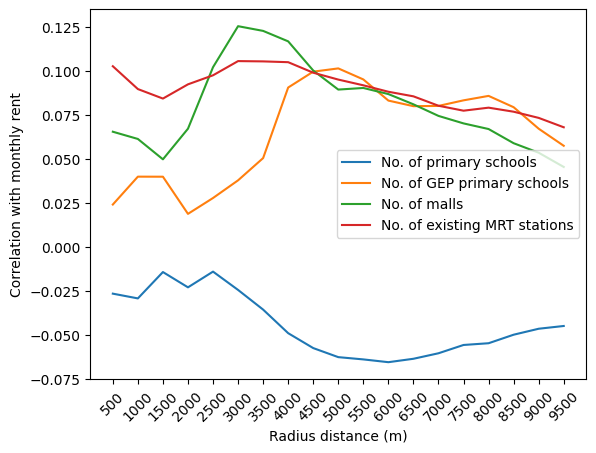

In [24]:
lower_limit = 500
upper_limit = 10000
distance_range = range(lower_limit, upper_limit, 500)

plt.plot(distance_range, sch_corrs, label="No. of primary schools")
plt.plot(distance_range, gep_corrs, label="No. of GEP primary schools")
plt.plot(distance_range, mall_corrs, label="No. of malls")
plt.plot(distance_range, mrt_corrs, label="No. of existing MRT stations")

plt.xlabel("Radius distance (m)")
plt.ylabel("Correlation with monthly rent")
plt.xticks(distance_range, rotation=45)
plt.legend()

### Plot overall correlation metrics for Schools, Malls, MRT data

In [27]:
df_training["gep_schools_within_5km"] = gep_tree.query_radius(training_coords, r=5000, count_only=True)
df_training["pri_schools_within_6km"] = sch_tree.query_radius(training_coords, r=6000, count_only=True)
df_training["malls_within_3km"] = mall_tree.query_radius(training_coords, r=3000, count_only=True)
df_training["mrts_within_3km"] = mrt_tree.query_radius(training_coords, r=3000, count_only=True)

gep_distances, _ = gep_tree.query(training_coords, k=1)  # k=1 for finding the nearest point
df_training['nearest_distance_to_gep'] = gep_distances

mrt_distances, _ = mrt_tree.query(training_coords, k=1)  # k=1 for finding the nearest point
df_training['nearest_distance_to_mrt'] = mrt_distances

mall_distances, _ = mall_tree.query(training_coords, k=1)  # k=1 for finding the nearest point
df_training['nearest_distance_to_mall'] = mall_distances

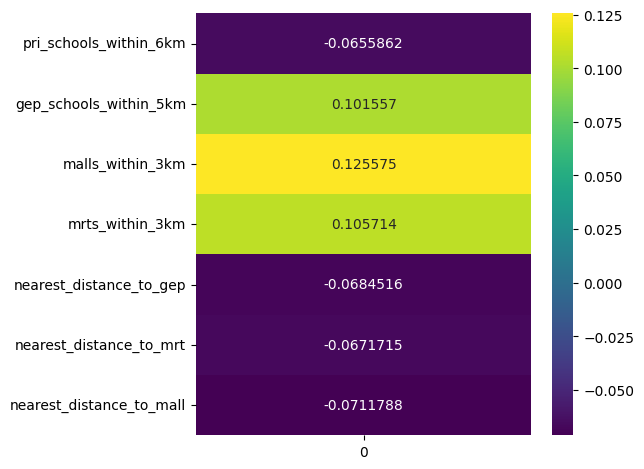

In [28]:
df_training_aux = df_training[['pri_schools_within_6km', 'gep_schools_within_5km', 
                   'malls_within_3km', 'mrts_within_3km', 
                   'nearest_distance_to_gep', 'nearest_distance_to_mrt',
                   'nearest_distance_to_mall']]

df_cor = df_training_aux.corrwith(df_training['monthly_rent']).to_frame()

hmap = sns.heatmap(df_cor, annot=True, fmt="g", cmap='viridis')
plt.tight_layout()

#### XGBoost model hyperparameter tuning

In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost_utils import prep_data_for_xgboost
from xgboost_utils import preprocess_xgboost

In [14]:
X_train, y_train, X_val, y_val = prep_data_for_xgboost()

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)


In [15]:
depth = range(3, 9)
estimators = range(1000, 2400, 200)
errors = []
for est in estimators:
    print('------ Estimators: ', est, '------')
    nerrors = []
    for d in depth:

        xgb_model = xgb.XGBRegressor(
                n_estimators=est, max_depth=d, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        nerrors.append(error)
        print(d, ":", error)
    errors.append(nerrors)

------ Estimators:  1000 ------
3 : 484.7036369909077
4 : 482.93277099012886
5 : 481.91616216925115
6 : 481.8935836332019
7 : 482.88394321017944
8 : 484.9251447901518
------ Estimators:  1200 ------
3 : 484.19843739216003
4 : 482.6607685651501
5 : 481.773135481189
6 : 481.89628538852116
7 : 483.2833445336488
8 : 485.90708557653136
------ Estimators:  1400 ------
3 : 483.80830259654107
4 : 482.2640179186864
5 : 481.58945378728055
6 : 481.91163080894404
7 : 483.5603686584294
8 : 486.82241372642204
------ Estimators:  1600 ------
3 : 483.6002402033278
4 : 482.04389667869697
5 : 481.5257144752266
6 : 482.1770194684275
7 : 484.18201362414186
8 : 487.9719617782136
------ Estimators:  1800 ------
3 : 483.35439290569104
4 : 481.87427522122414
5 : 481.4906954982108
6 : 482.3819344289789
7 : 484.8500615818786
8 : 489.2065004089727
------ Estimators:  2000 ------
3 : 483.17806629248105
4 : 481.772847742912
5 : 481.50952024849136
6 : 482.57907659762816
7 : 485.47115222927
8 : 490.4036011054124
---

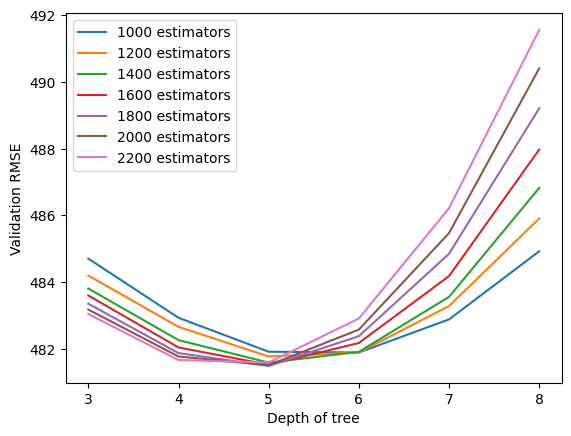

In [16]:
plt.plot(depth, errors[0], label="1000 estimators")
plt.plot(depth, errors[1], label="1200 estimators")
plt.plot(depth, errors[2], label="1400 estimators")
plt.plot(depth, errors[3], label="1600 estimators")
plt.plot(depth, errors[4], label="1800 estimators")
plt.plot(depth, errors[5], label="2000 estimators")
plt.plot(depth, errors[6], label="2200 estimators")

plt.xlabel("Depth of tree")
plt.ylabel("Validation RMSE")
plt.legend()

#### Perform K-Fold Validation on optimal settings

In [17]:
def kfold_xgboost(enc='target'):
    training_data_raw = pd.read_csv('train.csv')
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    scores = []
    for train_index, val_index in kfold.split(training_data_raw):
        X_train, X_val = training_data_raw.iloc[train_index], training_data_raw.iloc[val_index]

        X_train = preprocess_xgboost(X_train, encoder=enc)
        X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
        X_val = preprocess_xgboost(X_val, True, enc)
        X_val, y_val = X_val.drop('monthly_rent', axis=1), X_val[['monthly_rent']]
        
        xgb_model = xgb.XGBRegressor(
                n_estimators=1800, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        scores.append(error)

    return scores

In [20]:
scores = kfold_xgboost()

/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = count_aux_within_radius
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_raw[col_name] = aux_distances
/Users/biqing/Documents/2023-fall/cs5228/project/cs5228_project_commit/xgboost_utils.py:60: SettingWithCopyWarning: 
A value is trying to 

In [22]:
print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}\nMin: {3:.3f}\nMax: {4:.3f}".format(
    scores, np.mean(scores), np.std(scores), np.min(scores), np.max(scores)
))

Scores: [472.54645242178646, 489.26631158155595, 489.39966656967033, 480.27854377851986, 481.3439959083697, 476.6714879007348, 483.57077881779713, 487.84295118884927, 475.77179452488633, 485.16404753545896]
Mean: 482.186
Std: 5.602
Min: 472.546
Max: 489.400
